In [94]:
from pettingzoo.mpe import simple_spread_v2
from pettingzoo.utils import AssertOutOfBoundsWrapper
from pettingzoo.utils import aec_to_parallel

import time
import pettingzoo
pettingzoo.__version__
import sys
import torch  
import gym
# from tqdm import tqdm
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [95]:
class A2CTD0:
    def __init__(self, env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma) -> None:
        self.env = env
        self.obs_size = obs_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_episodes = num_episodes
        self.num_steps = num_steps
        self.gamma = gamma

        # self.model = ActorCriticSingleAgent(self.obs_size * self.env.observation_space.shape[0] + 1, self.output_size, self.hidden_size, self.learning_rate)
    
    def _get_action(self, actor_act_pred):
        # Sample an action according the probs the network just output.
        action = np.random.choice(self.output_size, p=np.squeeze(actor_act_pred))
        return action

    def _obs_to_tensor(self, obs):
        state_tensor = torch.flatten(F.one_hot(torch.tensor(obs, dtype=torch.int64), num_classes=self.obs_size))
        # add a bias bit with a value of 1 in front of the one hot vector
        state_tensor = torch.cat((torch.tensor([1.0]), state_tensor))
        return state_tensor

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            state_values = np.zeros((10, 10))
            for i in range(1, 11):
                for j in range(1, 11):
                    state_tensor = self._obs_to_tensor([i, j])
                    value, _ = self.model.forward(state_tensor.float())
                    state_values[i-1][j-1] = value.detach().numpy()
            # show the value of each state with matplot lib
            # plt.imshow(state_values)
            # plt.show()
                # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) 
                # + "\nCurrent State: " + str(state)
                )
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: {}, total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            rewards = []
            done = False
            i = 1

            state = self.env.reset()
            steps = 0
            # enable n step actor critic. 
            while not done:
                state_tensor = self._obs_to_tensor(state)
                critic_td_error, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_action(detached_act_pred)

                # Calculate the log probability of the action we've taken
                log_prob = torch.distributions.Categorical(actor_act_pred).log_prob(torch.tensor(action))

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                new_state, reward, done, _, _ = self.env.step(action)
                steps += 1

                state = new_state
                
                state_tensor = self._obs_to_tensor(state)
                if not done:
                  q_val_tensor, _ = self.model.forward(state_tensor.float())
                else:
                    q_val_tensor = torch.tensor(0)
                    all_lengths.append(steps)
                    average_lengths.append(np.mean(all_lengths[-10:]))
                td_error = reward + self.gamma * q_val_tensor - critic_td_error
        
                # update actor critic
                actor_loss = -log_prob * (reward + self.gamma * q_val_tensor.item() - critic_td_error.item())
                actor_loss *= i
                critic_loss = 0.5 * td_error ** 2
                critic_loss *= i

                ac_loss = actor_loss + critic_loss + 0.001 * entropy

                ac_optimizer.zero_grad()
                ac_loss.backward()
                ac_optimizer.step()
                # all_entropies.append(entropy)
                all_losses.append(ac_loss.detach().numpy())
                i *= self.gamma
            if done:
              episode_rewards.append(np.sum(rewards))
            self._show_episode_results(episode, steps, state, all_losses, average_lengths)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [96]:
"""
This is a single agent actor-critic implementation.
It is specifically designed to work with the four rooms environment, but it should work with any gym environment.
"""

import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd


def obs_to_tensor(obs: np.array) -> torch.Tensor:
    # initialize an empty np array
    obs_tensor = np.array([])
    for _, value in obs.items():
        obs_tensor = np.concatenate((obs_tensor, value))
    return torch.Tensor(obs_tensor)



In [97]:
class ActorCriticCentralizedMultiAgent(nn.Module):
    """
    A simple, but flexible, implementation of the actor-critic algorithm.
    """
    def __init__(self, num_inputs, num_actions, actions_per_agent, hidden_size, learning_rate=3e-4):
        super(ActorCriticCentralizedMultiAgent, self).__init__()

        self.num_actions = num_actions
        self.actions_per_agent = actions_per_agent
        # estimate the value function
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, hidden_size)
        self.critic_linear3 = nn.Linear(hidden_size, len(self.actions_per_agent))

        # estimate the policy distribution
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, hidden_size)
        self.actor_linear3 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        """
        Do inference to calculate the action probabilities and the state value.
        """
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        value = self.critic_linear3(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        # softmax effectively generates a probability for each of our output options
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = self.actor_linear3(policy_dist)
        # reshape the policy dist for each actor
        policy_dist = policy_dist.view((len(self.actions_per_agent), self.actions_per_agent[0]))

        policy_dist = F.softmax(policy_dist, 1)

        return value, policy_dist

In [98]:
min_vals = np.zeros((6))
max_vals = np.zeros((6))
min_adj = np.ones((6))
max_adj = np.zeros((6))

class A2CTDNCentralizedMultiAgent(A2CTD0):
    def __init__(self, env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes, num_steps, gamma) -> None:
        super().__init__(env, obs_size, hidden_size, output_size, learning_rate, num_episodes, num_steps, gamma)
        self.actions_per_agent = actions_per_agent

        self.model = ActorCriticCentralizedMultiAgent(self.obs_size + 1, self.output_size, actions_per_agent, self.hidden_size, self.learning_rate)
    
    def _get_actions(self, actor_act_pred, num_agents):
        # Sample an action according the probs the network just output.
        idx = 0
        actions = {}
        for agent in self.env.agents:
            action_space_size = self.env.action_space(agent).n
            action = np.random.choice(action_space_size, p=np.squeeze(actor_act_pred[idx]))
            actions[agent] = action
            idx += 1
        return actions

    def _show_episode_results(self, episode, steps, state, all_losses, average_lengths, rewards, frequency):
        if episode % frequency == 0:
            # make an array of the value of each state currently
            # make an empty array for the values of each state of shape 10x10
            # state_values = np.zeros((10, 10))
            # for i in range(1, 11):
            #     for j in range(1, 11):
            #         state_tensor = self._obs_to_tensor([i, j])
            #         value, _ = self.model.forward(state_tensor.float())
            #         state_values[i-1][j-1] = value.detach().numpy()
            # # show the value of each state with matplot lib
            # # plt.imshow(state_values)
            # # plt.show()
            #     # sys.stdout.write("\nState: " + str(i) + " Value: " + str(state_values))
            sys.stdout.write("\nLoss: " + str(all_losses[-1]) + "\nRewards: " + str(rewards[-1]) + "\n" + "Average last 20 Rewards" + str(np.mean(rewards[-20:])))
                # + "\nCurrent State: " + str(state))
            # Where total length is the number of steps taken in the episode and average length is average steps in all episodes seen 
            sys.stdout.write("\nepisode: " + str(episode))
            # global min_vals, max_vals, min_adj, max_adj
            # sys.stdout.write("\nmin_vals: " + str(min_vals))
            # sys.stdout.write("\nmax_vals: " + str(max_vals))
            # sys.stdout.write("\nmin_adj: " + str(min_adj))
            # sys.stdout.write("\nmax_adj: " + str(max_adj))
            #total length: {}, average length of prev 10: {} \n".format(episode, steps, average_lengths[-1]))

    def _obs_to_tensor(self, obs: np.array) -> torch.Tensor:
        # initialize an empty np array
        # we want to normalize these values so they are above 0
        # The form is: [agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + comm
        # first we'll just adjust the position of the agent from -1 - 1 to 0 - 1
        # This means the second and third obs values for each agent must be added by 1 and then divided by 2
        obs_tensor = np.array([1.0])
        # global min_vals, max_vals
        # # track the min and max values for each observation
        # for i, value in enumerate(list(obs.values())[0]):
        #     if value < min_vals[i]:
        #         min_vals[i] = value
        #     if value > max_vals[i]:
        #         max_vals[i] = value

        for _, value in obs.items():
            new_array = np.concatenate([np.array(value[0:2] + 2) / 4, np.array((value[2:4]  + 25) / 50), (np.array(value[4:]) + 25) / 50])
            # global min_adj, max_adj
            # for i, val in enumerate(list(new_array)):
            #     if val < min_adj[i]:
            #         min_adj[i] = val
            #     if val > max_adj[i]:
            #         max_adj[i] = val

            obs_tensor = np.concatenate((obs_tensor, value))
        return torch.Tensor(obs_tensor)

    def _combine_rewards(self, rewards):
        """
        Push the rewards into a tensor that can be handled by pytorch
        """
        return np.array(list(rewards.values())).T

    def _get_log_probs(self, actor_act_pred, actions):
        start = 0
        log_probs = []
        for agent in self.env.agents:
            action_space_size = self.env.action_space(agent).n
            log_probs.append(torch.distributions.Categorical(actor_act_pred[start: start + action_space_size]).log_prob(torch.tensor(actions[agent])))
            start += action_space_size
        return torch.concatenate(log_probs)

    def train(self):
        # Use Adam optimizer for the actor-critic because it should converge faster than SGD and generalization may not be super important
        ac_optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # all episode length
        all_lengths = []
        episode_rewards = []
        # average episode length
        average_lengths = []
        all_entropies = []
        all_losses = []

        for episode in range(self.num_episodes):
            single_episode_rewards = []
            done = False
            i = 1
            G = 0
            state = self.env.reset()
            steps = 0
            step_rewards = []
            states = [state]
            dones = []
            actions = []

            # enable n step actor critic. 
            while True:
                state_tensor = self._obs_to_tensor(state)
                _, actor_act_pred = self.model.forward(state_tensor.float())
                # drop the tensor dimension and computational graph info
                detached_act_pred = actor_act_pred.detach().numpy()
                action = self._get_actions(detached_act_pred, len(self.env.agents))

                actions.append(action)

                # Calculate the entropy/ uncertainty of the policy term. This is used to encourage exploration
                # entropy = -np.sum(np.mean(detached_act_pred) * np.log(detached_act_pred))
                # entropy_term += entropy
                new_state, rewards, done, _, _ = self.env.step(action)
                # time.sleep(.05)
                # done is a dict of agents. We only care if all agents are done
                done = all(done.values()) or len(self.env.agents) < 1
                if done:
                    break
                steps += 1

                state = new_state
                step_rewards.append(self._combine_rewards(rewards))
                dones.append(done)
                states.append(new_state)

                if len(step_rewards) >= self.num_steps:
                    if len(step_rewards) > self.num_steps:
                        step_rewards.pop(0)
                        states.pop(0)
                        dones.pop(0)
                        actions.pop(0)

                    # calculate G
                    G = 0
                    for idx, r in enumerate(step_rewards):
                        # account for the dones vector too
                        G += r * (self.gamma ** idx) * (1 - dones[idx])
                    single_episode_rewards.append(G)

                    critic_val, actor_act_pred = self.model.forward(self._obs_to_tensor(states[0]).float())
                    if len(self.env.agents) < 1:
                        print('where agent')
                    log_probs = self._get_log_probs(actor_act_pred, actions[0])
                    next_state_tensor = self._obs_to_tensor(states[-1])
                    if not dones[0]:
                        next_critic_value_tensor, _ = self.model.forward(next_state_tensor.float())
                    else:
                        # set a zeros tensor equal to the length of the number of agents
                        next_critic_value_tensor = torch.zeros(len(self.env.agents))
                    # calculate the n step td error
                    # td error = G + gamma ** self.num_steps * V(s_{t+n}) - V(s_t)
                    td_error = torch.tensor(G) + self.gamma ** self.num_steps * next_critic_value_tensor - critic_val


                    # update actor critic
                    actor_loss = -log_probs * (torch.tensor(G).detach() + self.gamma * next_critic_value_tensor.detach() - critic_val.detach())
                    actor_loss *= i
                    critic_loss = 0.5 * td_error ** 2

                    ac_loss = actor_loss + critic_loss# + 0.001 * entropy

                    ac_optimizer.zero_grad()
                    ac_loss.backward(
                        torch.ones_like(ac_loss)
                    )
                    ac_optimizer.step()
                    # all_entropies.append(entropy)
                    all_losses.append(ac_loss.detach().numpy())
                    i *= self.gamma


            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            discounted_episode_reward = 0
            for reward in single_episode_rewards[::-1]:
                discounted_episode_reward = reward + self.gamma * discounted_episode_reward
            episode_rewards.append(discounted_episode_reward)
            self._show_episode_results(episode, steps, states, all_losses, average_lengths, episode_rewards, 1000)
            
        return all_lengths, average_lengths, all_entropies, all_losses, episode_rewards

In [99]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [102]:
def run_it(num_steps, max_episodes, num_agents):
    hidden_size = 64
    learning_rate = 3e-4

    # Constants
    gamma = 0.99

    env = simple_spread_v2.env(N=num_agents, local_ratio=0.5, max_cycles=25, continuous_actions=False, 
    # render_mode="human"
    )

    env = AssertOutOfBoundsWrapper(env)
    env = aec_to_parallel(env)

    obs_dict = env.reset()
    state = env.state()
    # env.render()
    obs_size = obs_to_tensor(obs_dict).shape[0]
    output_size = 0
    actions_per_agent = []

    for i in range(len(env.agents)):
        output_size += env.action_space(env.agents[i]).n
        actions_per_agent.append(env.action_space(list(obs_dict.keys())[i]).n)

    many_run_lengths, many_run_average_lengths, many_run_entropies, many_run_losses, many_run_rewards = [], [], [], [], []

    for i in range(5):
        agent = A2CTDNCentralizedMultiAgent(env, obs_size, hidden_size, output_size, actions_per_agent, learning_rate, num_episodes=max_episodes, num_steps=num_steps, gamma=gamma)

        all_lengths, average_lengths, all_entropies, all_losses, episode_rewards = agent.train()
        # many_run_lengths.append(all_lengths)
        # many_run_average_lengths.append(average_lengths)
        # many_run_entropies.append(all_entropies)
        many_run_losses.append(np.sum(np.array(all_losses), 1))
        many_run_rewards.append(np.sum(np.array(episode_rewards), 1))
    return many_run_losses, many_run_rewards


In [103]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 15000
    num_agents = 1
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, 1)


Loss: [-0.66458188]
Rewards: [-19.3237757]
Average last 20 Rewards-19.32377569601312
episode: 0
Loss: [0.00024663]
Rewards: [-36.36861605]
Average last 20 Rewards-26.22200450221543
episode: 1000
Loss: [0.00622014]
Rewards: [-31.66785509]
Average last 20 Rewards-26.699612788143476
episode: 2000
Loss: [0.00460735]
Rewards: [-38.29631437]
Average last 20 Rewards-29.296240540643947
episode: 3000
Loss: [0.0015831]
Rewards: [-20.29804853]
Average last 20 Rewards-25.276984728206152
episode: 4000
Loss: [0.06206989]
Rewards: [-23.01441293]
Average last 20 Rewards-25.649660988422266
episode: 5000
Loss: [-0.04763225]
Rewards: [-20.41348626]
Average last 20 Rewards-28.481263816294994
episode: 6000
Loss: [0.00060409]
Rewards: [-20.03318008]
Average last 20 Rewards-26.47918322333703
episode: 7000
Loss: [0.00162635]
Rewards: [-40.63108867]
Average last 20 Rewards-27.030543594798775
episode: 8000
Loss: [-0.00178945]
Rewards: [-30.3838308]
Average last 20 Rewards-25.78540672136979
episode: 9000
Loss: 

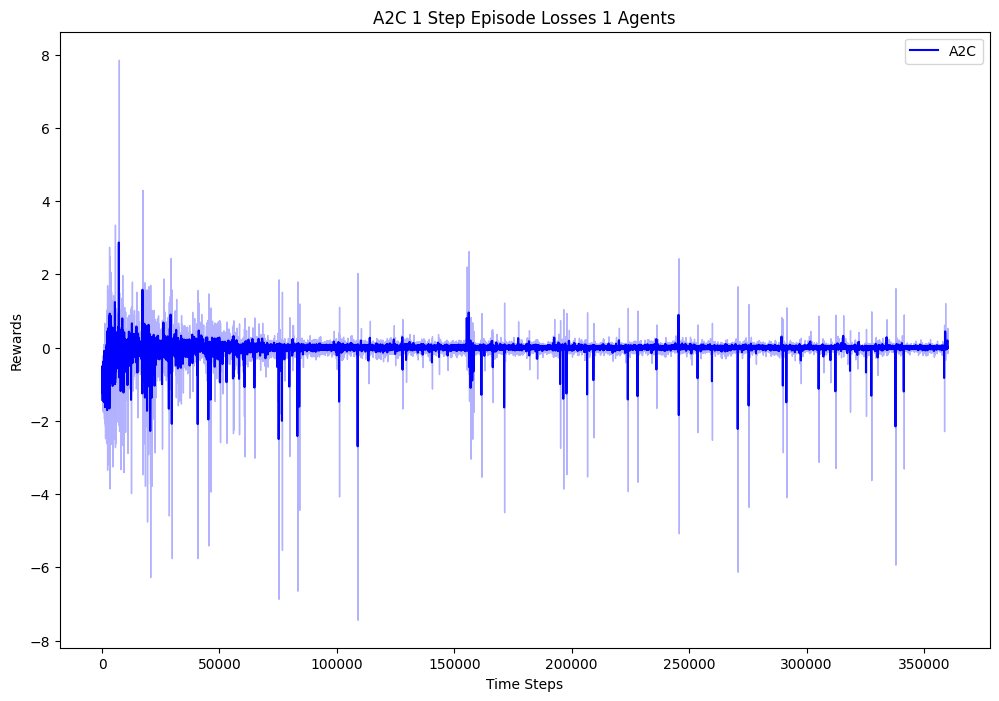

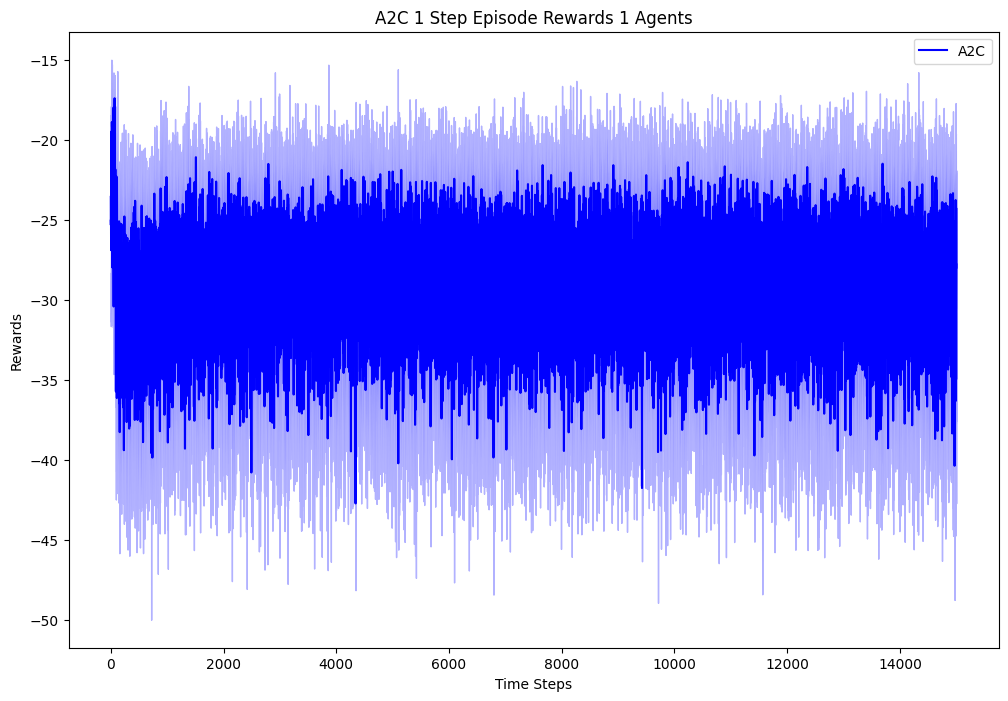

In [104]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 1 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 1 Agents")

In [109]:
# save episode rewards to a json file
import json

def list_of_np_arrays_to_list_of_lists(arr):
    return [arr[i].tolist() for i in range(len(arr))]

# many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
# many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_1step_rewards1_agent.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses1_agent.json', 'w') as f:
    json.dump(many_run_losses, f)

In [110]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 15000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [-0.70466039 -1.14044806]
Rewards: [-22.50705915 -22.50705915]
Average last 20 Rewards-22.50705915438581
episode: 0
Loss: [ 0.04658751 -0.18351011]
Rewards: [-33.63860281 -33.63860281]
Average last 20 Rewards-29.677466162801853
episode: 1000
Loss: [ 0.00099385 -0.59114555]
Rewards: [-19.7176281 -19.7176281]
Average last 20 Rewards-31.802806244968302
episode: 2000
Loss: [ 0.11650699 -6.02956869]
Rewards: [-54.51524322 -54.51524322]
Average last 20 Rewards-37.02540651874463
episode: 3000
Loss: [ 0.00070521 -0.08731344]
Rewards: [-33.93165183 -33.93165183]
Average last 20 Rewards-34.48734854170423
episode: 4000
Loss: [0.00589462 0.00618896]
Rewards: [-31.71426392 -31.71426392]
Average last 20 Rewards-31.068000195886203
episode: 5000
Loss: [0.00981142 0.08067158]
Rewards: [-29.88125554 -29.88125554]
Average last 20 Rewards-32.34224158554017
episode: 6000
Loss: [0.02036432 0.04991591]
Rewards: [-31.58223068 -31.58223068]
Average last 20 Rewards-32.960671249098276
episode: 7000
Loss: 

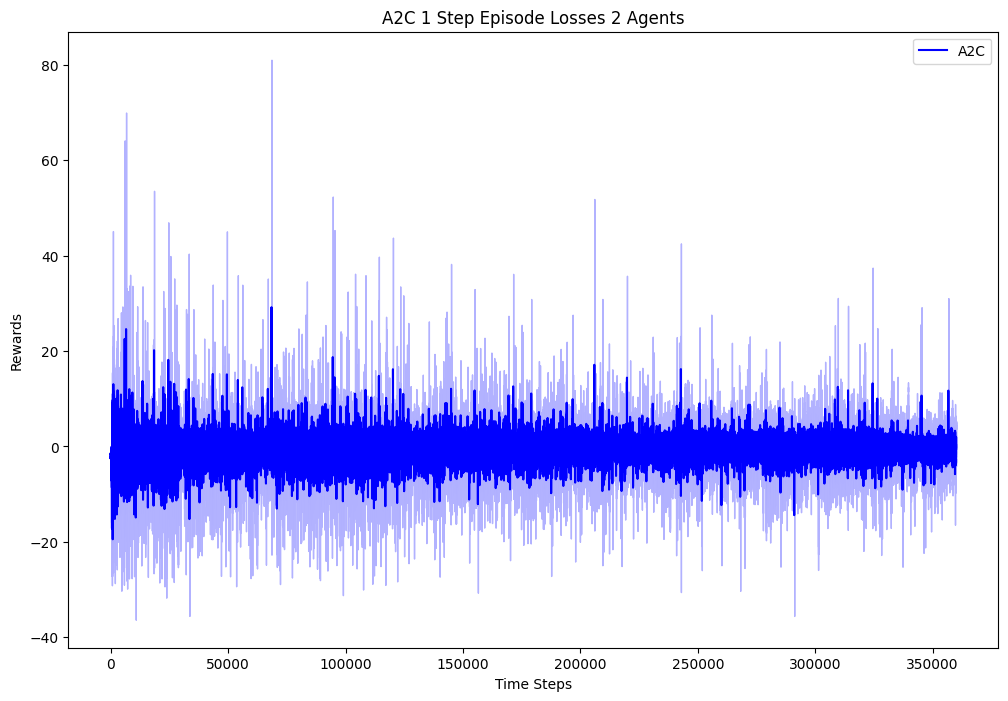

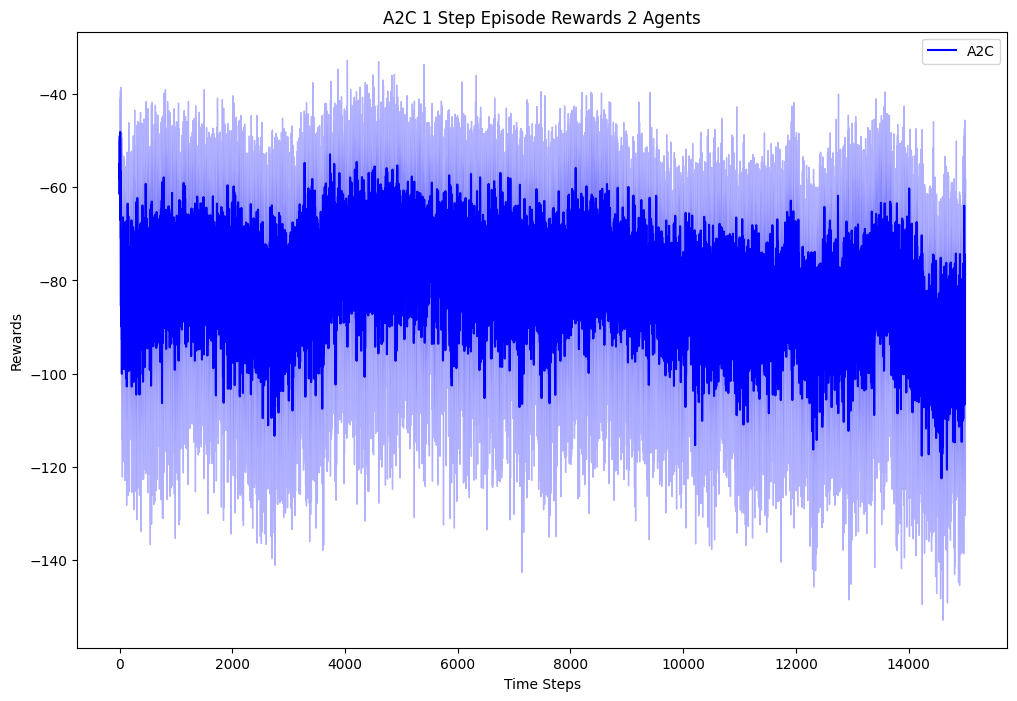

In [111]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 2 Agents")

In [112]:
def list_of_np_arrays_to_list_of_lists(arr):
    return [arr[i].tolist() for i in range(len(arr))]

many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_1step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [113]:
if __name__ == '__main__':
    num_steps = 1
    max_episodes = 20000
    num_agents = 3
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [-0.67106362 -0.16625995 -1.31792528]
Rewards: [-30.74156631 -30.74156631 -30.74156631]
Average last 20 Rewards-30.741566312367514
episode: 0
Loss: [0.00336384 1.21769415 0.44479271]
Rewards: [-40.617327 -40.617327 -40.617327]
Average last 20 Rewards-51.34682373739068
episode: 1000
Loss: [ 0.14453975 -6.597665    0.12700664]
Rewards: [-40.59701459 -40.59701459 -40.59701459]
Average last 20 Rewards-40.88461738857742
episode: 2000
Loss: [ 0.00382335 -1.32766399 -1.3107809 ]
Rewards: [-58.75358008 -58.75358008 -58.75358008]
Average last 20 Rewards-47.14965557028539
episode: 3000
Loss: [4.28150238e-04 1.35959184e-01 4.39634738e-01]
Rewards: [-33.75938737 -33.75938737 -33.75938737]
Average last 20 Rewards-37.95274276347024
episode: 4000
Loss: [0.0582956  4.07397693 4.07541258]
Rewards: [-44.27431065 -45.25936065 -45.25936065]
Average last 20 Rewards-35.51998744869786
episode: 5000
Loss: [0.11865931 6.38524502 6.51524353]
Rewards: [-25.75306626 -25.75306626 -25.75306626]
Average last 

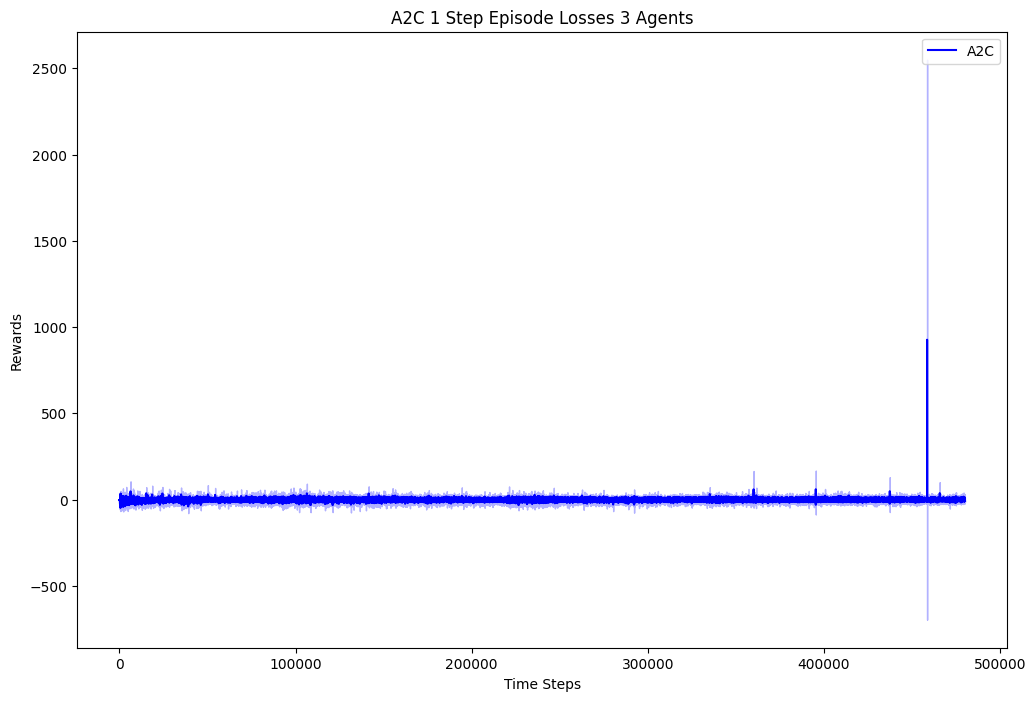

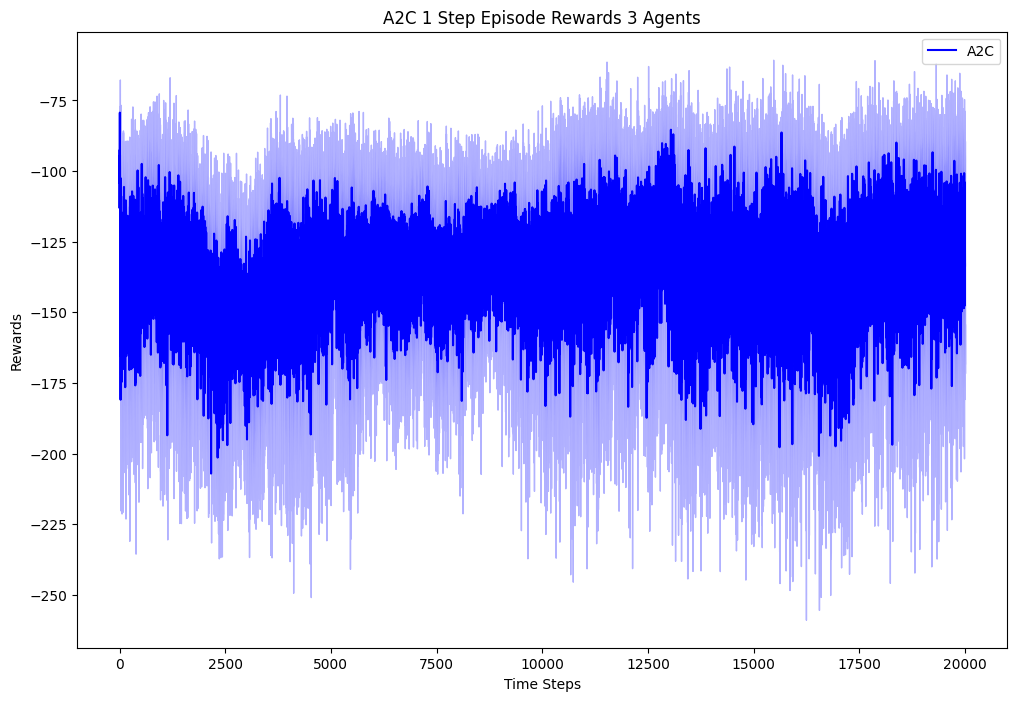

In [114]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Losses 3 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 1 Step Episode Rewards 3 Agents")

In [115]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)
with open('simple_spread_a2c_1step_rewards3_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses3_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [116]:
if __name__ == '__main__':
    num_steps = 2
    max_episodes = 15000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [1.61881576 1.40063143]
Rewards: [-61.55251433 -61.55251433]
Average last 20 Rewards-61.55251432780963
episode: 0
Loss: [0.02892931 0.02813652]
Rewards: [-78.91434356 -78.91434356]
Average last 20 Rewards-92.09632741827852
episode: 1000
Loss: [0.01095863 0.01292359]
Rewards: [-74.42867395 -74.42867395]
Average last 20 Rewards-101.58459199126438
episode: 2000
Loss: [0.00135946 0.0014361 ]
Rewards: [-108.10831879 -108.10831879]
Average last 20 Rewards-98.08462964417203
episode: 3000
Loss: [0.06335539 0.06297169]
Rewards: [-98.25019756 -98.25019756]
Average last 20 Rewards-95.98477696420021
episode: 4000
Loss: [0.16747406 0.16550396]
Rewards: [-98.89245078 -98.89245078]
Average last 20 Rewards-99.6044719266814
episode: 5000
Loss: [0.62101646 0.61673002]
Rewards: [-140.1791927 -140.1791927]
Average last 20 Rewards-99.13323942784747
episode: 6000
Loss: [0.05643743 8.09124131]
Rewards: [-88.05008911 -88.05008911]
Average last 20 Rewards-95.4764007106389
episode: 7000
Loss: [ 0.0254496

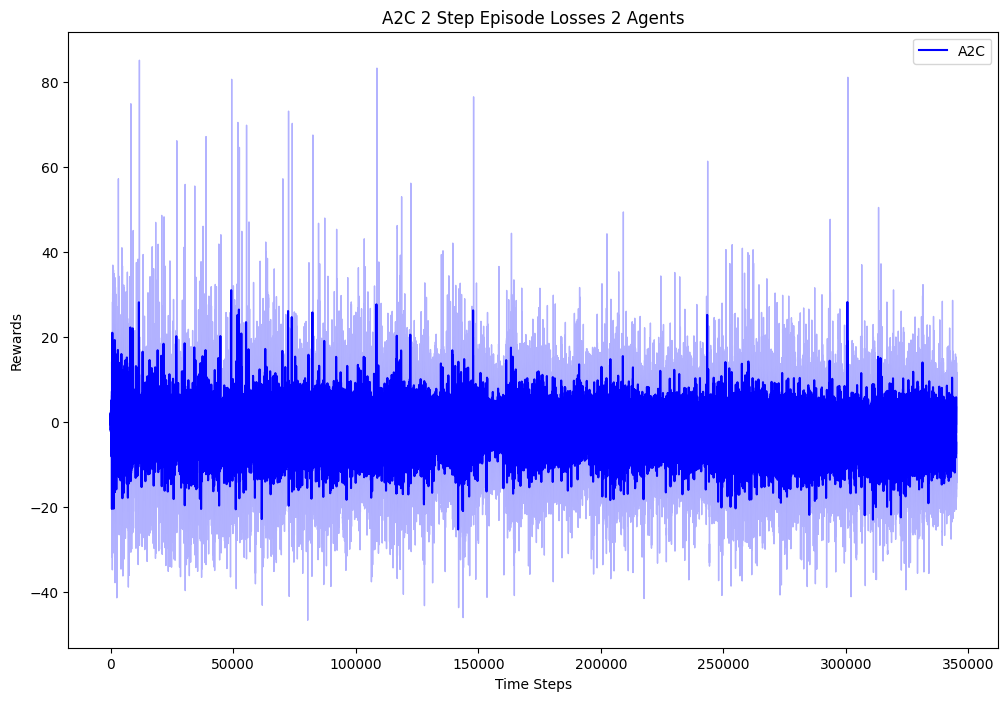

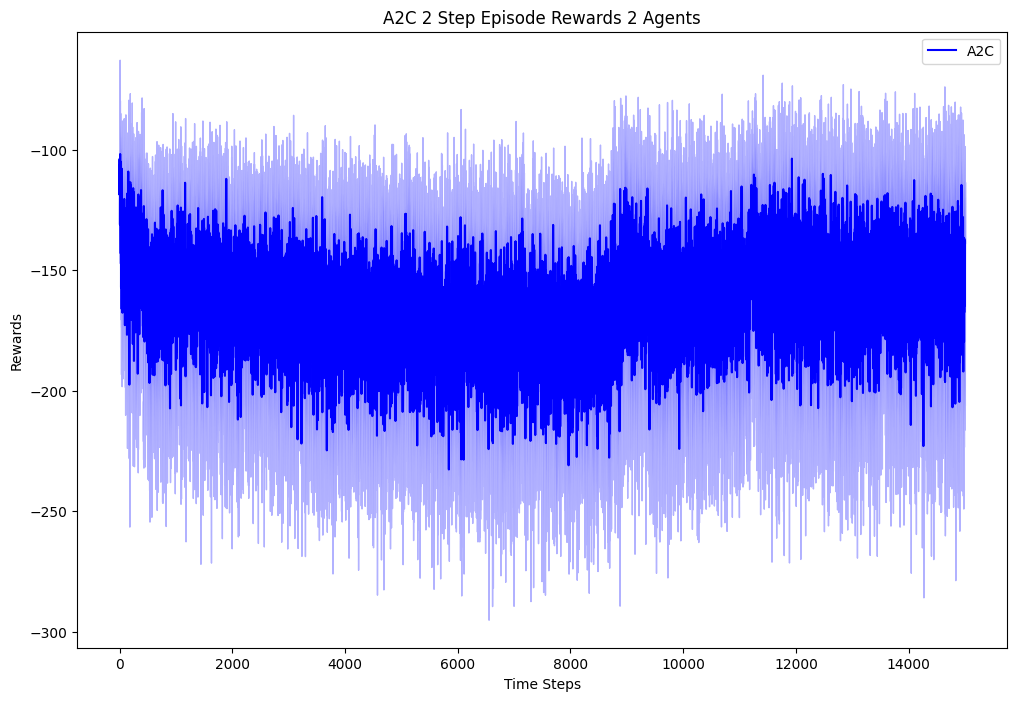

In [117]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 2 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 2 Step Episode Rewards 2 Agents")

In [118]:
with open('simple_spread_a2c_2step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_2step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [119]:
if __name__ == '__main__':
    num_steps = 4
    max_episodes = 15000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [6.49603826 6.26803241]
Rewards: [-88.86709396 -88.86709396]
Average last 20 Rewards-88.86709396471115
episode: 0
Loss: [0.07269386 0.07287683]
Rewards: [-113.77958424 -113.77958424]
Average last 20 Rewards-128.4635489920541
episode: 1000
Loss: [0.00943115 0.01100192]
Rewards: [-93.52707571 -93.52707571]
Average last 20 Rewards-131.0975546232324
episode: 2000
Loss: [3.36538279 3.3745435 ]
Rewards: [-158.22349566 -158.22349566]
Average last 20 Rewards-139.8153518431961
episode: 3000
Loss: [ 1.48119266 -4.64069641]
Rewards: [-187.18675707 -187.18675707]
Average last 20 Rewards-149.13359439617903
episode: 4000
Loss: [ 1.82954676 30.42553962]
Rewards: [-69.92335251 -69.92335251]
Average last 20 Rewards-108.013212333312
episode: 5000
Loss: [0.00558217 0.00795692]
Rewards: [-158.56883263 -158.56883263]
Average last 20 Rewards-154.87791068261845
episode: 6000
Loss: [0.05159074 0.05351469]
Rewards: [-114.3274037 -114.3274037]
Average last 20 Rewards-150.41601230869475
episode: 7000
Loss

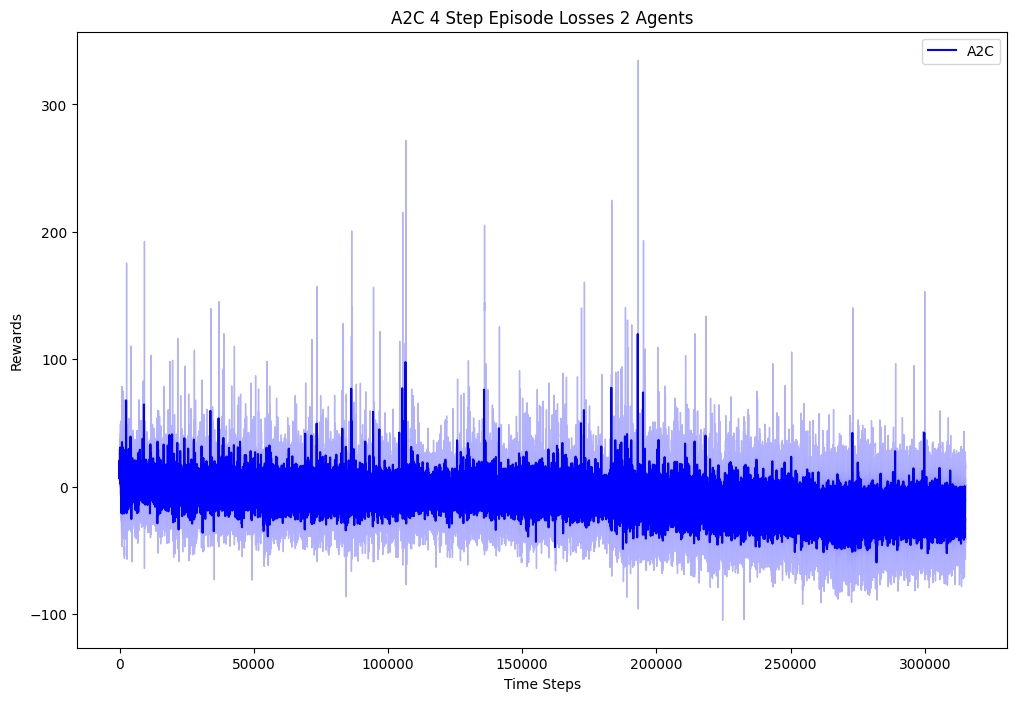

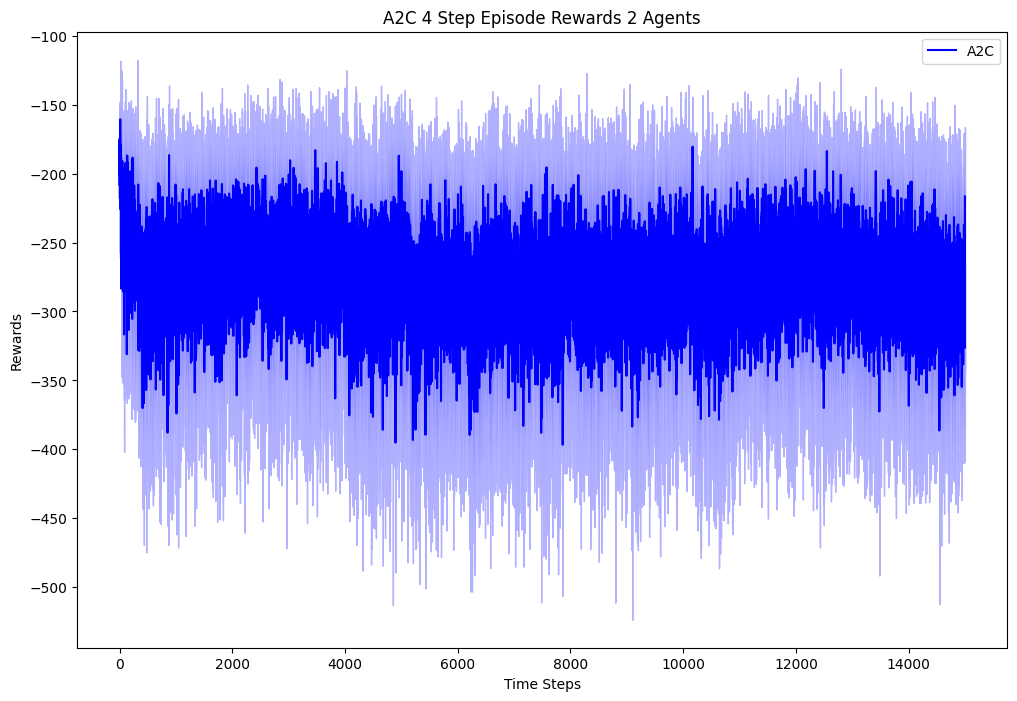

In [120]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 4 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 4 Step Episode Rewards 2 Agents")

In [121]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_4step_rewards2_agents.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_4step_losses2_agents.json', 'w') as f:
    json.dump(many_run_losses, f)

In [122]:
if __name__ == '__main__':
    num_steps = 8
    max_episodes = 15000
    num_agents = 2
    many_run_losses, many_run_rewards = run_it(num_steps, max_episodes, num_agents)


Loss: [31.30469842 33.28398424]
Rewards: [-130.40037258 -130.40037258]
Average last 20 Rewards-130.40037257828712
episode: 0
Loss: [0.03075053 0.03165582]
Rewards: [-250.93044955 -250.93044955]
Average last 20 Rewards-272.52819848353164
episode: 1000
Loss: [0.17052765 0.18019898]
Rewards: [-239.64866307 -239.64866307]
Average last 20 Rewards-263.88758241086333
episode: 2000
Loss: [0.25276838 0.26604613]
Rewards: [-218.58505291 -218.58505291]
Average last 20 Rewards-239.79085898178158
episode: 3000
Loss: [0.01768272 0.02024541]
Rewards: [-329.63114884 -329.63114884]
Average last 20 Rewards-265.64015193545504
episode: 4000
Loss: [0.12595725 0.12288906]
Rewards: [-234.1770708 -234.1770708]
Average last 20 Rewards-268.64646334626497
episode: 5000
Loss: [5.76204341 6.51266896]
Rewards: [-316.74943783 -316.74943783]
Average last 20 Rewards-261.24563647250545
episode: 6000
Loss: [0.0004386  0.00029476]
Rewards: [-139.83437224 -139.83437224]
Average last 20 Rewards-214.34118957341676
episode:

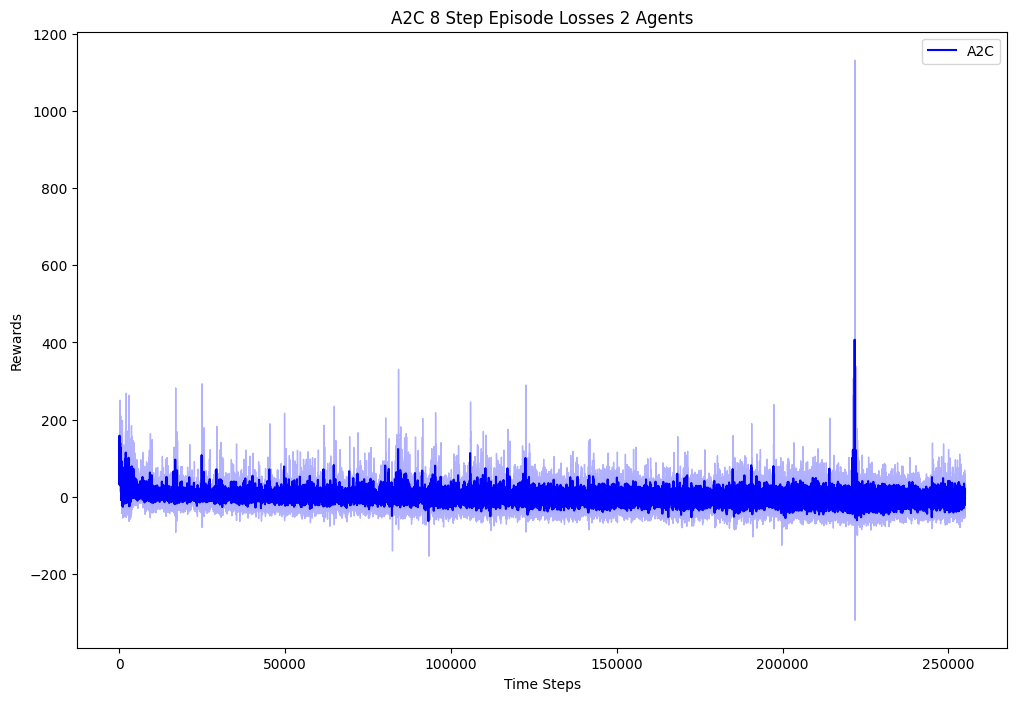

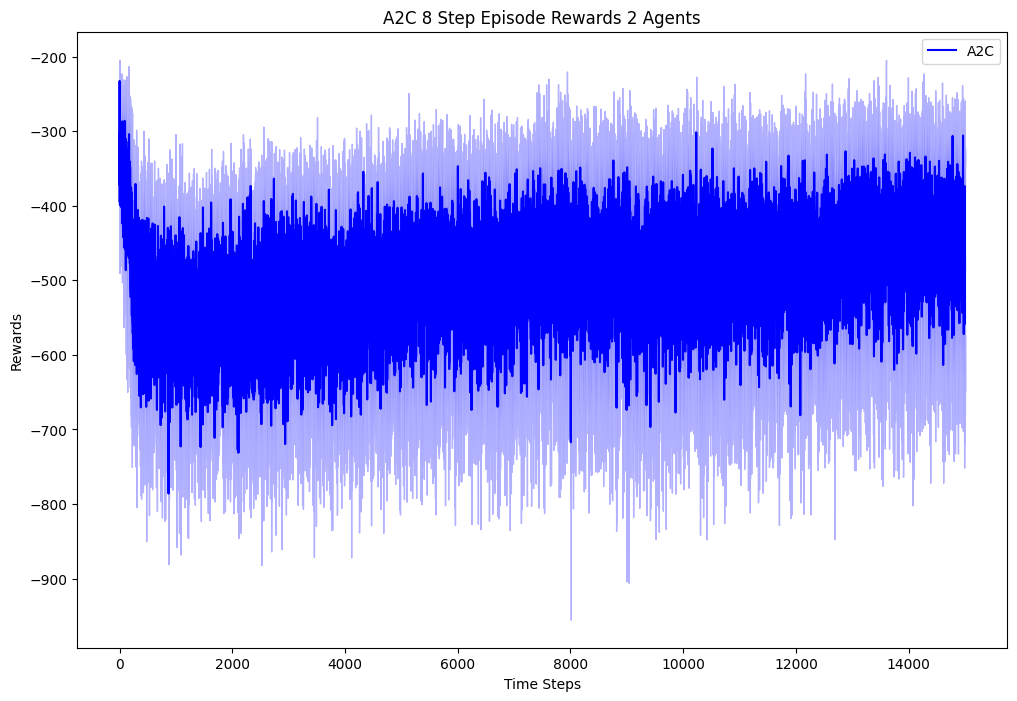

In [123]:
plot_curves([np.array(many_run_losses)], ["A2C"], ["blue"], "Rewards", "A2C 8 Step Episode Losses 2 Agents")
plot_curves([np.array(many_run_rewards)], ["A2C"], ["blue"], "Rewards", "A2C 8 Step Episode Rewards 2 Agents")

In [124]:
many_run_rewards = list_of_np_arrays_to_list_of_lists(many_run_rewards)
many_run_losses = list_of_np_arrays_to_list_of_lists(many_run_losses)

with open('simple_spread_a2c_1step_rewards2_agents_8_steps.json', 'w') as f:
    json.dump(many_run_rewards, f)

with open('simple_spread_a2c_1step_losses2_agents_8_steps.json', 'w') as f:
    json.dump(many_run_losses, f)